In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/My Drive/class20211/DS_2021/class_note/PyTorch

/content/drive/My Drive/class20211/DS_2021/class_note/PyTorch


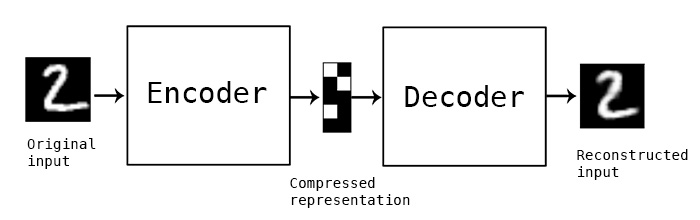

In [3]:
from IPython.display import Image
Image('AE_1.jpg', width=600, height=200)

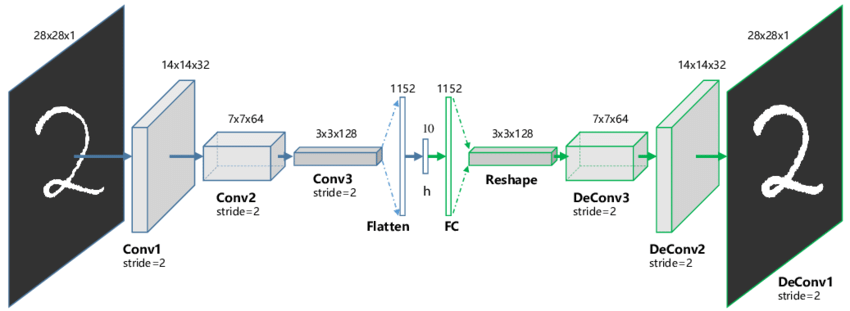

In [4]:
from IPython.display import Image
Image('CAE_1.png', width=600, height=200)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary
from torch.utils.data import DataLoader

#from pushover import notify
#from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

#%load_ext autoreload
#%autoreload 2

In [6]:
batch_size = 32
num_epochs= 50

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
trans = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [9]:
train_data = torchvision.datasets.ImageFolder(root='train', transform=trans)

In [10]:
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True, num_workers=2)

In [11]:
len(train_data.imgs),len(train_loader)

(492, 16)

torch.Size([32, 3, 64, 64])


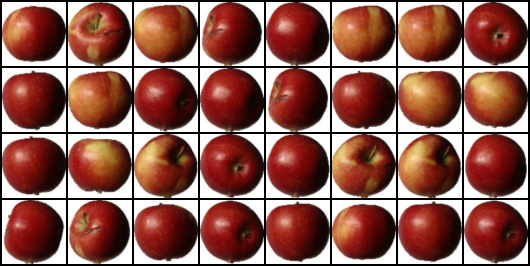

In [12]:
# Fixed input for debugging
fixed_x, _ = next(iter(train_loader))
print(fixed_x.shape)
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

In [13]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [14]:
class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 32, 14, 14)

In [33]:
class Autoencoder(nn.Module):
    def __init__(self, image_channels=3, z_dim=10):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 16, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten(),
        
            nn.Linear(6272, 256),
            nn.Linear(256, z_dim)
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.Linear(256, 6272),
        
            UnFlatten(),
        
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2),
            nn.ReLU(),
        
            nn.ConvTranspose2d(16, image_channels, kernel_size=4, stride=2),
            nn.Sigmoid()
        )
        


    def forward(self, x):
        out =self.encoder(x)
        out = self.decoder(out)
        return out

In [34]:
image_channels = fixed_x.size(1)


In [35]:
model = Autoencoder(image_channels=image_channels).to(device)

In [36]:
pip install pytorch_model_summary

In [37]:
import pytorch_model_summary
print(pytorch_model_summary.summary(model, torch.zeros(1, 3, 64, 64).to(device), show_input=False))

--------------------------------------------------------------------------
         Layer (type)        Output Shape         Param #     Tr. Param #
             Conv2d-1     [1, 16, 31, 31]             784             784
               ReLU-2     [1, 16, 31, 31]               0               0
             Conv2d-3     [1, 32, 14, 14]           8,224           8,224
               ReLU-4     [1, 32, 14, 14]               0               0
            Flatten-5           [1, 6272]               0               0
             Linear-6            [1, 256]       1,605,888       1,605,888
             Linear-7             [1, 10]           2,570           2,570
             Linear-8            [1, 256]           2,816           2,816
             Linear-9           [1, 6272]       1,611,904       1,611,904
         UnFlatten-10     [1, 32, 14, 14]               0               0
   ConvTranspose2d-11     [1, 16, 31, 31]          12,816          12,816
              ReLU-12     [1, 16, 31,

In [38]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

# set to training mode
model.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_loader:
        
        image_batch = image_batch.to(device)
        
        # autoencoder reconstruction
        image_batch_recon = model(image_batch)
        
        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 50] average reconstruction error: 0.104929
Epoch [2 / 50] average reconstruction error: 0.039297
Epoch [3 / 50] average reconstruction error: 0.025143
Epoch [4 / 50] average reconstruction error: 0.018403
Epoch [5 / 50] average reconstruction error: 0.012987
Epoch [6 / 50] average reconstruction error: 0.010423
Epoch [7 / 50] average reconstruction error: 0.008218
Epoch [8 / 50] average reconstruction error: 0.006953
Epoch [9 / 50] average reconstruction error: 0.006101
Epoch [10 / 50] average reconstruction error: 0.005322
Epoch [11 / 50] average reconstruction error: 0.004739
Epoch [12 / 50] average reconstruction error: 0.004362
Epoch [13 / 50] average reconstruction error: 0.004017
Epoch [14 / 50] average reconstruction error: 0.003845
Epoch [15 / 50] average reconstruction error: 0.003661
Epoch [16 / 50] average reconstruction error: 0.003467
Epoch [17 / 50] average reconstruction error: 0.003316
Epoch [18 / 50] average reconstruction error: 0.003129
Epoch 

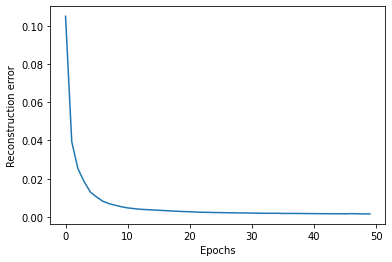

In [39]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

In [40]:
def compare(x):
    recon_x= model(x)
    return torch.cat([x, recon_x])

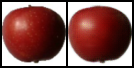

In [41]:
fixed_x = train_data[randint(1, 100)][0].unsqueeze(0)
compare_x = compare(fixed_x.to(device))

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=300, unconfined=True))